# Вариант 4. Сравнение GAP и Flatten
Цель: Понимание различий между Flatten и Global Average Pooling.

Спроектируйте сеть с 3 свёрточными слоями, после которых выходной тензор (batch, 128, 8, 8).

Условие: Реализуйте два варианта классификации:
Flatten → Linear

Global Average Pooling → Linear

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.optim import Adam
from collections import Counter
import numpy as np


(<PIL.Image.Image image mode=RGB size=32x32 at 0x12263A8C0>, 9)


(32, 32, 3)

## Flatten → Linear

In [2]:
class ConvNetFlatten(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
    self.linear = nn.Linear(in_features=128*8*8, out_features=10)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.conv2(x)
    x = torch.relu(x)
    x = self.conv3(x)
    x = torch.relu(x)
    #print('до linear: ', x.shape)
    features = torch.flatten(x, 1)
    x = self.linear(features)
    return x, features

## Global Average Pooling → Linear

In [3]:
class ConvNetGAP(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
    self.gap = nn.AdaptiveAvgPool2d(output_size=1)
    self.linear = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.conv2(x)
    x = torch.relu(x)
    x = self.conv3(x)
    x = torch.relu(x)
    #print('до linear: ', x.shape)
    #x = F.adaptive_avg_pool2d(x, 1)
    x = self.gap(x)
    features = torch.flatten(x, 1)
    x = self.linear(features)
    return x, features

In [4]:
test_tensor = torch.randn(1, 3, 32, 32)

model_flatten = ConvNetFlatten()
outputflatten, featuresflatten = model_flatten(test_tensor)

model_gap = ConvNetGAP()
outputgap, featuresgap = model_gap(test_tensor)

In [5]:
print(f"Flatten - output: {outputflatten.shape}, features: {featuresflatten.shape}")
print(f"GAP - output: {outputgap.shape}, features: {featuresgap.shape}")

Flatten - output: torch.Size([1, 10]), features: torch.Size([1, 8192])
GAP - output: torch.Size([1, 10]), features: torch.Size([1, 128])


### **Эксперимент: Обучите оба варианта на данных и сравните дисперсию выходных активаций перед финальным слоем.**

100%|██████████| 170M/170M [00:06<00:00, 26.6MB/s]


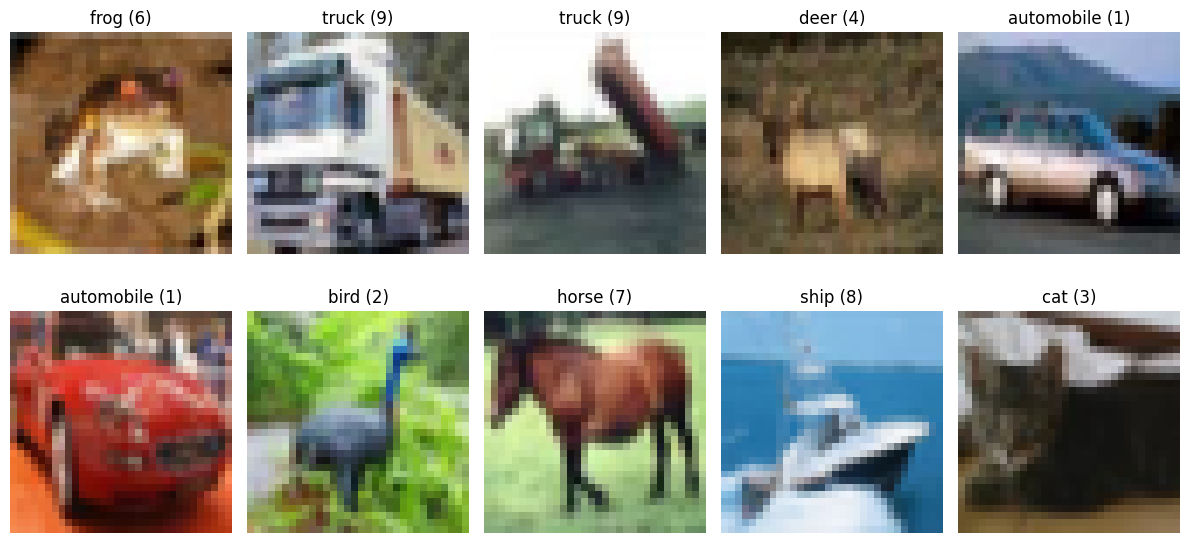

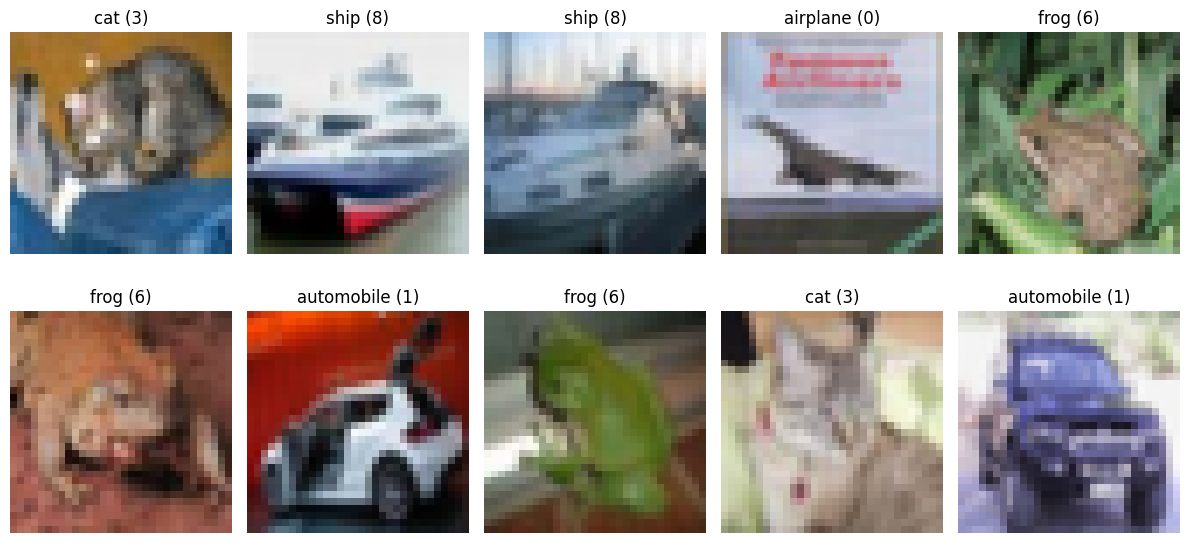

In [6]:
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=None)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=None)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_images):
        image, label = dataset[i]

        axes[i].imshow(image)
        axes[i].set_title(f'{classes[label]} ({label})')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


show_images(train_dataset)

show_images(test_dataset)

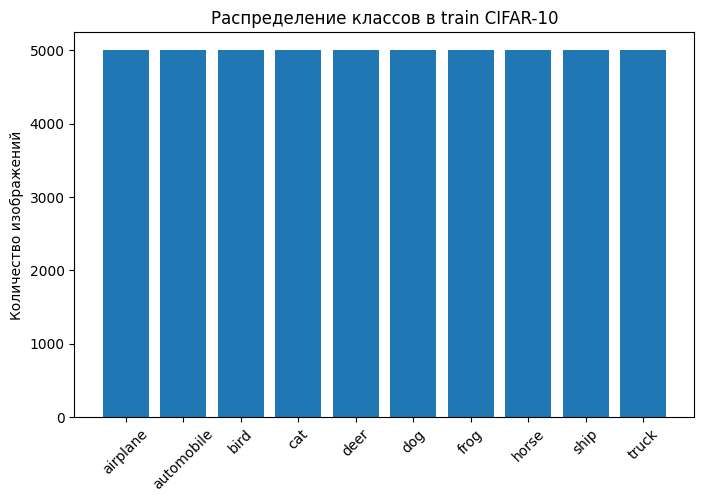

In [7]:
train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)

plt.figure(figsize=(8,5))
plt.bar(classes, [class_counts[i] for i in range(10)])
plt.title("Распределение классов в train CIFAR-10")
plt.xticks(rotation=45)
plt.ylabel("Количество изображений")
plt.show()

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
models = [ConvNetFlatten(), ConvNetGAP()]

In [10]:
criterion = nn.CrossEntropyLoss()

for model in models:
    optimizer = Adam(model.parameters(), lr=0.001)
    epochs = 5
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        train_losses = []

        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs, _ = model(images)

            loss = criterion(outputs, labels)
            train_losses.append(loss.item())
            loss.backward()

            optimizer.step()

        epoch_loss = sum(train_losses) / len(train_losses)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

    print(f'loss: {sum(train_losses)/len(train_losses):.4f}')
    print()

100%|██████████| 782/782 [01:00<00:00, 12.97it/s]


Epoch [1/5], Loss: 1.4640


100%|██████████| 782/782 [00:59<00:00, 13.15it/s]


Epoch [2/5], Loss: 1.1074


100%|██████████| 782/782 [00:59<00:00, 13.11it/s]


Epoch [3/5], Loss: 0.9389


100%|██████████| 782/782 [00:59<00:00, 13.17it/s]


Epoch [4/5], Loss: 0.8361


100%|██████████| 782/782 [01:00<00:00, 12.92it/s]


Epoch [5/5], Loss: 0.7527
loss: 0.7527



100%|██████████| 782/782 [00:58<00:00, 13.36it/s]


Epoch [1/5], Loss: 1.9079


100%|██████████| 782/782 [00:58<00:00, 13.31it/s]


Epoch [2/5], Loss: 1.6674


100%|██████████| 782/782 [00:58<00:00, 13.33it/s]


Epoch [3/5], Loss: 1.5637


100%|██████████| 782/782 [00:58<00:00, 13.26it/s]


Epoch [4/5], Loss: 1.4768


100%|██████████| 782/782 [00:58<00:00, 13.28it/s]

Epoch [5/5], Loss: 1.4134
loss: 1.4134



In [11]:
for model in models:
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

Accuracy: 68.87%
Accuracy: 50.27%


Flatten: variance = 0.023, shape = torch.Size([10000, 8192])
GAP: variance = 0.287, shape = torch.Size([10000, 128])


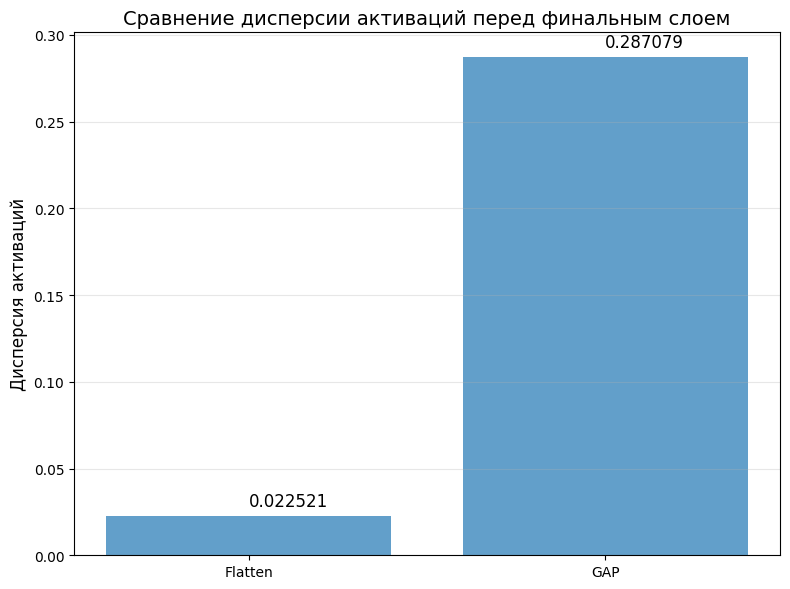

In [12]:
model_names = ['Flatten', 'GAP']
variances = []

for model in models:
    model.eval()
    all_activations = []

    with torch.no_grad():
        for images, _ in test_loader:
            _, activations = model(images)
            all_activations.append(activations.cpu())

    all_activations = torch.cat(all_activations, dim=0)

    variance = torch.var(all_activations, dim=0).mean().item()
    variances.append(variance)

    print(f"{model_names[models.index(model)]}: variance = {variance:.3f}, shape = {all_activations.shape}")

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, variances, alpha=0.7)

for i, v in enumerate(variances):
    plt.text(i, v + max(variances)*0.02, f'{v:.6f}', fontsize=12)

plt.ylabel('Дисперсия активаций', fontsize=12)
plt.title('Сравнение дисперсии активаций перед финальным слоем', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

у flattenа больше признаков, поэтому дисперсия низкая

#Вариант 6. Использование разных типов пулинга

Цель: Сравнение MaxPool и Global Average Pooling.

Спроектируйте сеть для входа (3, 64, 64) и выхода (32, 8, 8).
Условие: В сети обязательно должны быть и MaxPool2d, и AdaptiveAvgPool2d.

In [13]:
class ConvMaxPool(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.max_pool = nn.MaxPool2d(2, 2)
    self.gap = nn.AdaptiveAvgPool2d(output_size=8)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)
    x = self.pool2(x)

    x_max = self.max_pool(x)
    x_gap = self.gap(x)
    return x_gap, x_max

In [14]:
test_tensor = torch.randn(1, 3, 64, 64)
model = ConvMaxPool()
X_gap, X_max = model(test_tensor)

print(f"Input:     {test_tensor.shape}")
print(f"GAP:  {X_gap.shape}")
print(f"MaxPool:   {X_max.shape}")

Input:     torch.Size([1, 3, 64, 64])
GAP:  torch.Size([1, 32, 8, 8])
MaxPool:   torch.Size([1, 32, 8, 8])


## Эксперимент: Сравните выходы после MaxPool и GAP на одном и том же случайном тензоре, визуализируйте карты признаков и среднее значение активаций.

In [15]:
gap_np = X_gap.detach().numpy()
maxpool_np = X_max.detach().numpy()
diff = np.abs(gap_np - maxpool_np)
#diff

In [16]:
print(f"Разница:")
print(f"  Mean: {diff.mean():.4f}")
print(f"  Max:  {diff.max():.4f}")

print(f"GAP:")
print(f"  Min:  {gap_np.min():.4f}")
print(f"  Max:  {gap_np.max():.4f}")

print(f"MaxPool:")
print(f"  Min:  {maxpool_np.min():.4f}")
print(f"  Max:  {maxpool_np.max():.4f}")

Разница:
  Mean: 0.3285
  Max:  1.4554
GAP:
  Min:  0.5266
  Max:  1.7949
MaxPool:
  Min:  0.6667
  Max:  2.4986


In [17]:
def plot_feature_map(x, ax, title, show_numbers=True):
    im = ax.imshow(x, cmap='hot', interpolation='nearest')

    if show_numbers and x.shape[0] <= 4 and x.shape[1] <= 4:
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                ax.text(j, i, f'{x[i, j]:.1f}',
                        color='white', fontsize=8)

    ax.set_title(title, fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    return im

In [18]:
X_gap = X_gap[0]
X_max = X_max[0]

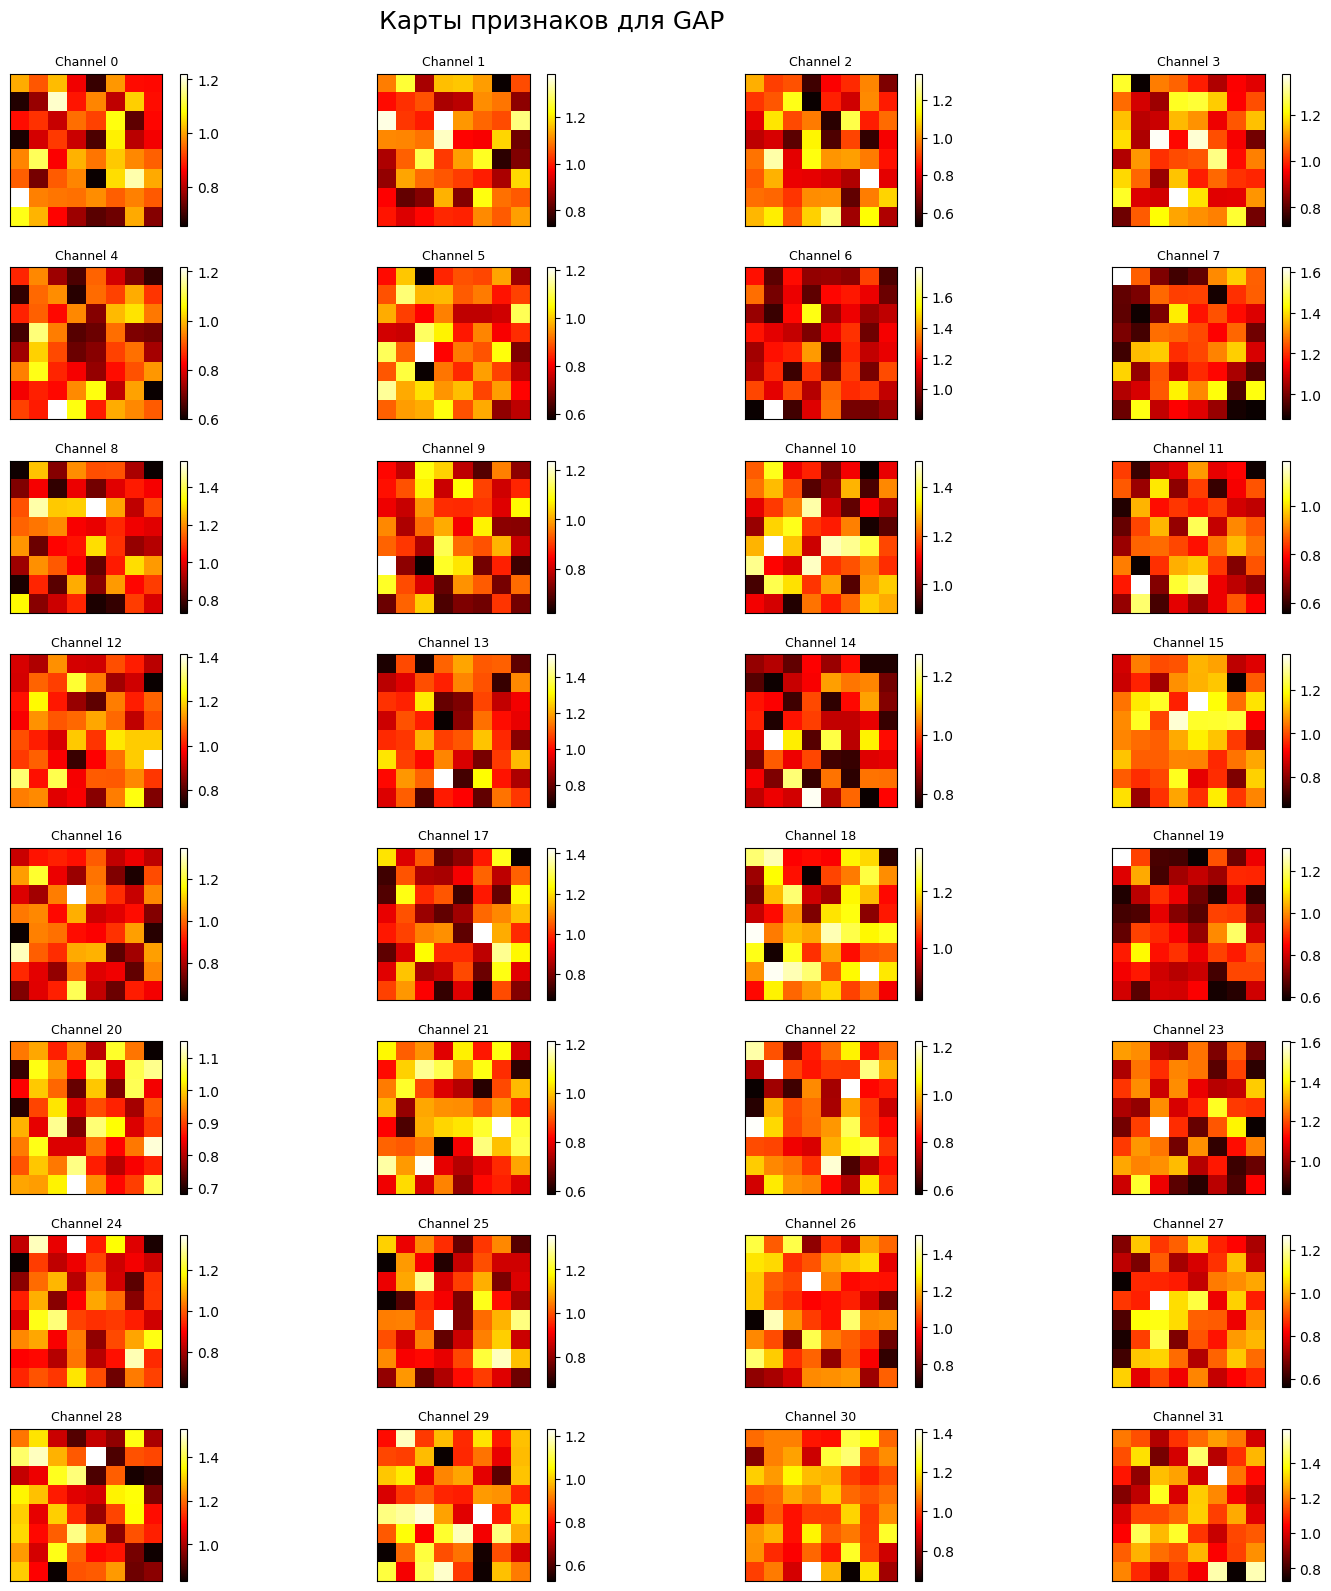

In [19]:
fig1, axes = plt.subplots(ncols=4, nrows=8, figsize=(16, 16))
axes = axes.flatten()

for k, (ax, x) in enumerate(zip(axes, X_gap)):
    x = x.detach().numpy()
    plot_feature_map(x, ax, f'Channel {k}', show_numbers=False)

plt.suptitle('Карты признаков для GAP', fontsize=18, y=0.995)
plt.tight_layout()
plt.show()

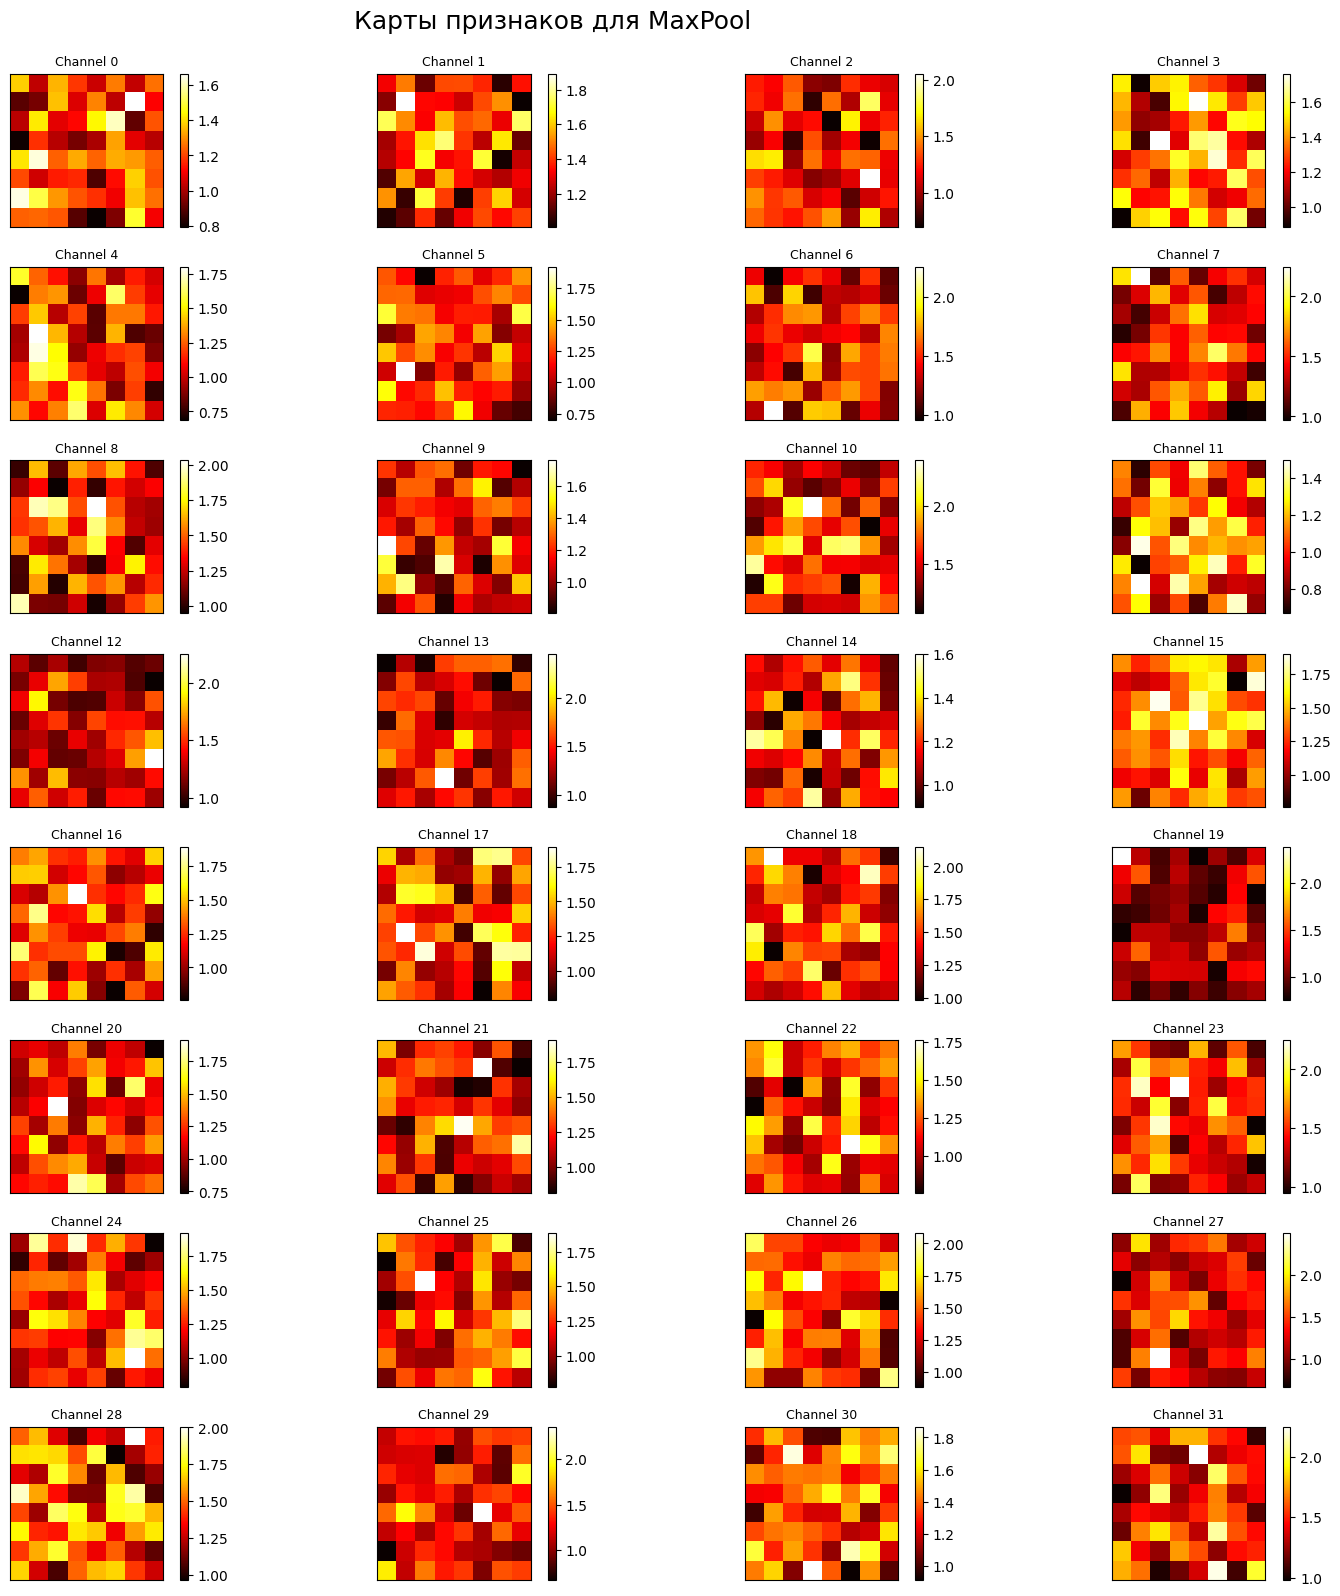

In [20]:
fig2, axes = plt.subplots(ncols=4, nrows=8, figsize=(16, 16))
axes = axes.flatten()

for k, (ax, x) in enumerate(zip(axes, X_max)):
    x = x.detach().numpy()
    plot_feature_map(x, ax, f'Channel {k}', show_numbers=False)

plt.suptitle('Карты признаков для MaxPool', fontsize=18, y=0.995)
plt.tight_layout()
plt.show()

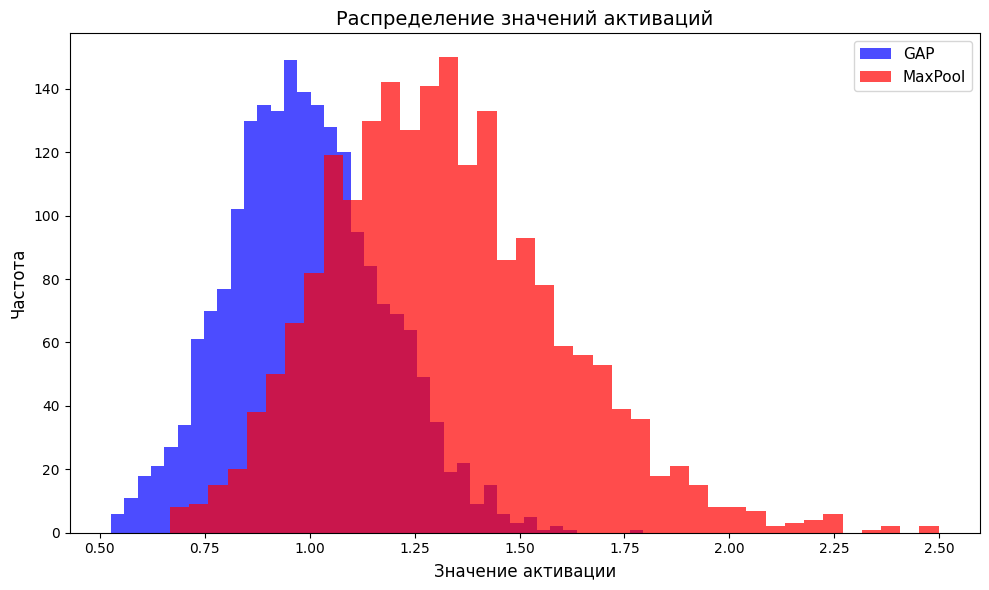

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(gap_np.flatten(), bins=40, alpha=0.7, label='GAP', color='blue')
ax.hist(maxpool_np.flatten(), bins=40, alpha=0.7, label='MaxPool', color='red')
ax.set_xlabel('Значение активации', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)
ax.set_title('Распределение значений активаций', fontsize=14)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

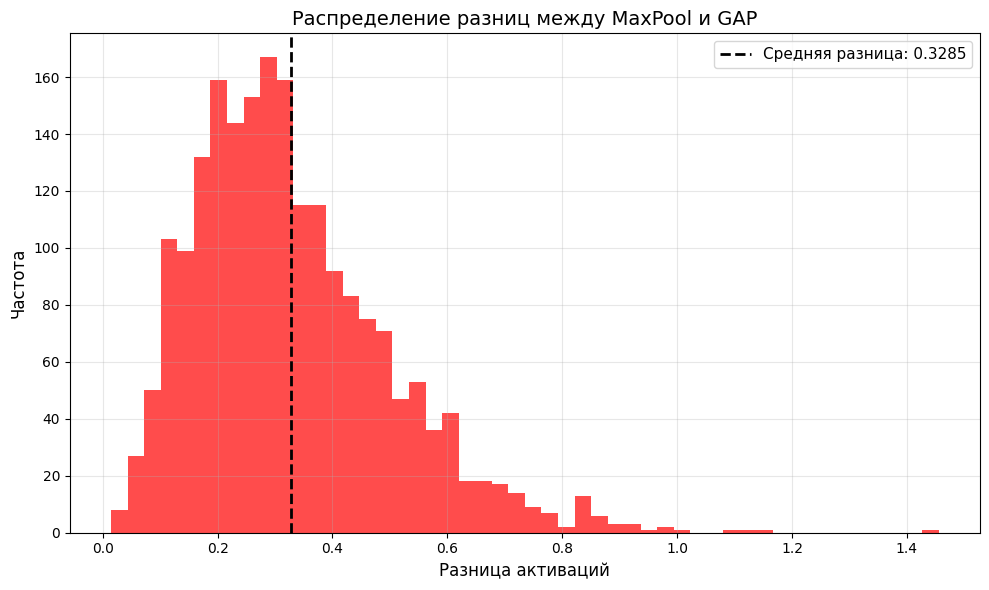

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(diff.flatten(), bins=50, alpha=0.7, color='red')
ax.axvline(diff.mean(), color='black', linestyle='--', linewidth=2,
           label=f'Средняя разница: {diff.mean():.4f}')

ax.set_xlabel('Разница активаций', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)
ax.set_title('Распределение разниц между MaxPool и GAP', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

у gap распределение центрировано около 0.9-1.0, почти нормальное

у maxpool есть хвост справа, более широкое распределение

разница такая, т.к gap сглаживает значения к среднему